The first exercise of this homework contains small unrelated questions on code. The final exam may contain similar questions, in which you will be asked to analyze or correct a piece of code. 

The second exercise uses a physics dataset on which we perform linear classification.

In [1]:
# don't forget to run this command before running the script!

import pandas as pd
import numpy as np
np.random.seed(0)

import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score


## Exercise 1 (6 pt)

In [186]:
def loss(x, y, w, l):
    # x is a n \times d matrix, y is a vector
    return np.sum((y - x.dot(w))**2 / 2) + (l / 2) * np.sum(np.abs(w))

**Question 1 (1 pt)** What loss, seen in class, is computed by the function `loss` ? Explain in what contexts it is used, compared to other losses.

_Answer_ : This is the LASSO loss which is computed here. We can see that this loss uses L1 regularization and is generally used for the sparse linear regression. As the L2 regularization can be seen as a circle, the L1 regularization space of solutions can be seen as a diamond-like shape in the contour plot due to the absolute value function. In almost all directions, the point of minimization will tend join the space of w in the corner, leading in more general cases of L1 regularization to sparsity for the estimated w_hat where many components will be 0. Since many components will be 0, this regularization is important, notably in signal processing, because it can reduce considerably the time and the memory needed to reconstruct a signal. 

In [212]:
def ridge_estimator(x, y, l):
    n, d = x.shape
    return x.T @ x + l * np.eye(d) @ x.T @ y

**Question 2 (1 pt)** We want the function `ridge_estimator` defined above to compute the estimator that minimizes the Ridge loss. Is there any mistake in this code ? If yes, fix it.

_Answer_ : The mistake is that we should take the inverse of the following term : (x.T @ x + l * np.eye(d))

In [213]:
# Fixing the mistake
def ridge_estimator_fixed(x, y, l):
    n, d = x.shape
    return np.linalg.inv(x.T @ x + l * np.eye(d)) @ x.T @ y

In [214]:
def gradient_descent(x, y, B):
    """
    arguments:
        x -- n x d matrix
        y -- n vector
        B -- integer
    """
    # compute an estimator using gradient descent
    n, d = x.shape
    w = np.zeros(d)
    tolerance = 1e-3
    diff = np.inf

    eta = 0.1
    
    while diff > tolerance:
        w_old = np.copy(w)

        indices = np.random.choice(n, B)
        x_batch = x[indices]
        y_batch = y[indices]
        
        w -= eta * np.dot(x_batch.T, np.dot(x_batch, w) - y_batch)

        diff = np.sum((w_old - w)**2) / d
    return w

**Question 3 (2 pt)** The goal of the function `gradient_descent` is to compute an estimator using stochastic gradient descent.

a) What is the value of the regularization here ? 

_Answer_ : Here we can see that there is no explicit sign of regularization in the gradient descent function. This function only aims to calculate the gradient and then update the weigths up to a certain tolerance on the differential. Therefore there is no term like L1 or L2 regularization here.

b) Explain the role of the variable `eta`. 

_Answer_ : Eta is the learning rate and describes the step size we will take at each iteration of the gradient descent, If eta is too small, we will converge really slowly to a minimum of the function. On the other hand, if eta is too large, there is a possibility of missing a minimum and then diverge or oscillate around a minimum without converging.

c) What line(s) would you change (and how) to perform gradient descent instead of stochastic gradient descent ?

_Answer_ : I would change the following line : w -= eta * np.dot(x_batch.T, np.dot(x_batch, w) - y_batch).  
Indeed, the gradient descent is dealing with all samples to perform each component of the gradient of the loss function over the weights while the SGD uses subsets of the complete dataset, called mini-batches, to compute an approximation of the gradient. This allows for faster weight updates at each iteration, but at the cost of a less accurate estimation of the gradient.
The lign would be changed by : w -= eta * np.dot(x.T, np.dot(x, w) - y). The learning rate could be also adjusted since we are dealing with more samples and in the MSE, there is a 1/n factor which has been deliberately omitted here.

**Question 4 (2 pt)** In the function `gradient_logistic_l2`, implement the gradient of the following loss (as before, we use here labels equal to $\pm 1$) :
$$
    \mathcal{L}(\vec{w}) = \frac{1}{n} \left( \sum_{i = 1}^n \log \left( 1 + e^{- y_i \times \vec{w}^{\top} \vec{x}_i} \right) + \frac{\lambda}{2} \| \vec{w} \|^2 \right)
$$


In [217]:
def gradient_logistic_l2(w, X, y, l):
    # your code here 
    n,d = X.shape
    z = X @ w
    gradient = np.zeros(d)
    cal = 1/(1+np.exp(y * z))
    for k in range(d):
        gradient[k] = (-np.sum(y * X[:,k] * cal) + l * w[k])/n
    return gradient

## Exercise 2 (10 pt)

In this exercise, we will perform linear classification on the SUSY dataset. Here, each data sample corresponds to particle collision event, which will be either from background noise (label `0`) or a supersymmetric event (label `1`). The input is made of $18$ numerical features related to the collision.

Because the original dataset is quite large (more than 1 GB), we will work with a small version of it containing 10000 training samples, that you can download on the Moodle page, called `susy_small.csv`.

### Data preparation

First, we will clean the data to make it more convenient to work with.

In [218]:
def load_dataset():
    df = pd.read_csv('susy_small.csv')
    # TODO your code here 
    x=df.values[:,1:]
    y=df.values[:,0]
    return x, y

**Question 1 (1 pt)** a) Implement the function `load_dataset` to return two numpy arrays `x` and `y`. `y` must contain the values in the column `SUSY` of the dataframe `df`, while `x` contains the rest of the data.

b) Observe the values taken by the labels $y$. Transform them such that they are either $-1$ or $1$ to be coherent with the notation seen in class.

In [131]:
def label_to_pm_one(y):
    y_new = np.where(y == 0, -1, 1) # your code here
    return y_new

**Question 2 (1 pt)** As good practice, it is preferable to have normalized data that is to say that the mean of the input matrix `X` accross its first first dimension should be $0$, and its variance should be $1$. This is not the case here. We then want to write a function that does two things : 1) split the data into training and validation sets and 2) normalize the training data. 

Here are two possible functions, `function1` and `function2` written for this purpose. Which of them is preferrable to the other and why ? 

_Reminder_ : The function `sklearn.model_selection.train_test_split` splits a given dataset `X`, `y` into a training and test data. The role of  the argument `random_state=0` is for reproducibility purposes.

_Answer_ : It is preferable to normalize the training data and use the statistics from the training data to normalize the test data. This better reflects reality because in real-world applications the test data is not known in advance. This being said, we have to use the statistics of the training set to normalize the test set. Moreover the function2 uses statistics calculated from the complete dataset (train + test), which can introduce bias. In fact, the statistics of the test set should not be used during the model training process since we are not suppose to know them yet.

In [219]:
def function1(x, y):
    # First split into training and validation, then compute the mean and variance of training data to normalize
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    mean_x_train = np.mean(x_train, axis = 0)
    var_x_train  = np.var(x_train, axis = 0)
    x_train = (x_train - mean_x_train) / np.sqrt(var_x_train)
    x_test  = (x_test  - mean_x_train) / np.sqrt(var_x_train)
    return x_train, x_test, y_train, y_test

def function2(x, y):
    # First compute the mean and variance of data, then split into training and validation
    mean_x = np.mean(x, axis = 0)
    var_x  = np.var(x, axis = 0)
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    x_train = (x_train - mean_x) / np.sqrt(var_x)
    x_test  = (x_test  - mean_x) / np.sqrt(var_x)
    return x_train, x_test, y_train, y_test

function_normalize = function1
# function_normalize = function2

### Logistic regression

**Question 4 (4 pt)** We want to run two methods to clasify the data : logistic regression with $\ell_1$ and $\ell_2$ penalty. 

a) First, implement the functions `logistic_l2` and `logistic_l1` that compute and returns the estimator for their corresponding losses. To this end, use the `sklearn.linear_model.LogisticRegression` class with the appropriate choice of penalty.

_Important note_ : in the initialization of `LogisticRegression`, set the argument `solver='liblinear'` to avoid an error.

In [222]:
def logistic_l1(x, y, l):
    # your code here
    lr =lm.LogisticRegression(penalty='l1', C=1/l, solver='liblinear').fit(x,y)
    return lr
def logistic_l2(x, y, l):
    # your code here
    lr =lm.LogisticRegression(penalty='l2', C=1/l, solver='liblinear').fit(x,y)
    return lr

b) Implement the functions `logistic_l2_crossvalidation` and `logistic_l1_crossvalidation` that compute the accuracy on the _validation data_ of the estimators trained for different values of $\lambda$ : for a list `lambda_range` that contains a list of the $\lambda$ to be tested, the function should return another list of the same length that contains the accuracy for each $\lambda$.

In [223]:
def logistic_l2_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    #your code here
    accuracy_val = []
    for l in lambda_range:
        model = logistic_l2(x_train, y_train, l)
        accuracy_val.append(accuracy_score(y_val, model.predict(x_val)))
    return accuracy_val  # Correct indentation here

def logistic_l1_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    #your code here
    accuracy_val = []
    for l in lambda_range:
        model = logistic_l1(x_train, y_train, l)
        accuracy_val.append(accuracy_score(y_val, model.predict(x_val)))
    return accuracy_val  # Correct indentation here


c) Using the functions of the previous questions, plot the validation accuracy for `lambda_range = np.logspace(-2, 5, 50)` for both $\ell_1$ and $\ell_2$ regularizations (don't hesitate to use a logarithmic scale for the x-axis). What are the optimal values $\lambda_1, \lambda_2$ ? 

_Answer_ : The best lambda for L1 regularization is :  37.27593720314938  
The best lambda for L21 regularization is :  13.894954943731374

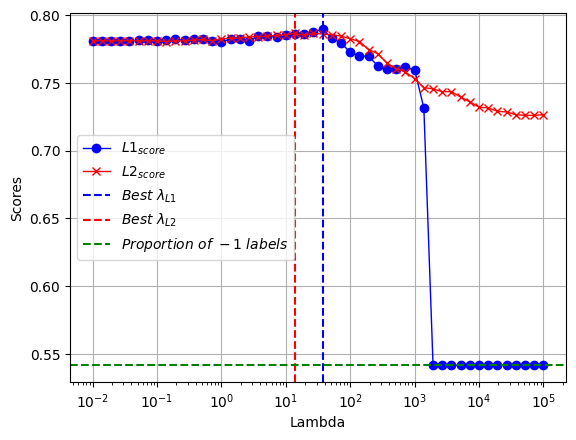

The best lambda for L1 regularization is : 37.27593720314938
The best lambda for L2 regularization is : 13.894954943731374
Proportion of -1 labels in the validation set is : 0.5415


In [224]:
# 1) load the data and normalize it 
xs,ys = load_dataset()
ys = label_to_pm_one(ys)
x_train, x_val, y_train, y_val = function_normalize(xs,ys)

# 2) compute the scores for logistic regression with l1 penalty
lambda_range = np.logspace(-2, 5, 50)
l1_score = logistic_l1_crossvalidation(x_train, y_train, x_val, y_val, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
l2_score = logistic_l2_crossvalidation(x_train, y_train, x_val, y_val, lambda_range)

best_lambda_l1 = lambda_range[np.argmax(l1_score)]
best_lambda_l2 = lambda_range[np.argmax(l2_score)]

# Here we compare if the score corresponds to the proportion of background events when lambda becomes very large
def proportion_negative_labels(y):
    count_negative = np.sum(y == -1)
    proportion_negative = count_negative / len(y)
    return proportion_negative

proportion_neg = proportion_negative_labels(y_val)

# 4) plot the scores as a function of lambda_range
#uncomment to visualize the results
plt.figure()
plt.plot(lambda_range, l1_score,'-o', color="blue", label=r"$L1_{score}$", markersize=6, linewidth=1)
plt.plot(lambda_range, l2_score, '-x', color="red", label=r"$L2_{score}$", markersize=6, linewidth=1)
plt.axvline(x=best_lambda_l1, color="blue", linestyle='--', label=r'$Best\ \lambda_{L1}$')
plt.axvline(x=best_lambda_l2, color="red", linestyle='--', label=r'$Best\ \lambda_{L2}$')
plt.axhline(y=proportion_neg, color="green", linestyle='--', label=r'$Proportion\ of\ -1\ labels$')

plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.grid()
plt.show()

# 5) print the best lambda for l1 and l2 penalties
print(f"The best lambda for L1 regularization is : {best_lambda_l1}")
print(f"The best lambda for L2 regularization is : {best_lambda_l2}")
print(f"Proportion of -1 labels in the validation set is : {proportion_neg}")

d) When $\lambda$ is big enough, the validation accuracy for $\ell_1$ regularization becomes constant to some value (let's call it $acc_{\infty}$). Justify that $acc_{\infty}$ is equal to the proportion of background events (i.e samples with label $-1$) in the validation data.

_Answer_ : When lambda becomes very large, the regularization forces the model's coefficients to zero since the cost is more important to overcome the parameter lambda while tryig to minimize the loss, than setting the coefficient to 0. Therefore, this leads to predict the same class for all data points, regardless of their features. In this case, the model loses its predictive power and simply assigns all observations to the majority class (likely the background events, labeled as -1). To summarize, the accuracy acc∞ becomes equal to the proportion of background events in the validation data, as the model always predicts this majority class. Also here we added the horizontal green curve which allows us to see that the model assigns all obsevervation to the majority class and is correct (ie the score) in a proportion corresponding to the one of the -1 labels.

### Adding interacting polynomial features

In this section, we will try to improve our classifier by adding features in our data, namely the product of the 18 existing features. That is to say, for all pair of indices $0 \leqslant i, j \leqslant 17$ with $i \neq j$ we will add the feature `X[:, i] * X[:, j]` to the matrix `X` (to have 171 features in total).

**Question 5 (1 pt)** Implement the function `add_interactions` to add the features described above.

_Hint_ : You can use a class seen in the exercise session to do so, with the correct arguments `degree` and `interaction_only`. The final dimension should be 171.


In [225]:
def add_interactions(X):
    # youre code here
    poly = pp.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_interactions = poly.fit_transform(X)
    return X_interactions

**Question 6 (3 pt)** Redo the steps of question 4 to find the optimal regularization strength $\lambda_{1, poly}$ and $\lambda_{2, poly}$ that correspond to the best validation accuracy. Did the validation accuracy improve compared to question 4 ? 

_NOTE_ : The computation may take some time, so be patient.

_Answer_ : The best lambda for L1 regularization is : 2.6826957952797246.  
The best lambda for L2 regularization is : 1.9306977288832496.
After adding interactions, we obtained for both regularization lower lambda, meaning that the model became more complex and therefore requiring weaker regularization to avoid overfitting and to generalize well. We can say that adding those features had an impact on the model's ability to fit correctly the data. Also we can see that the score curves (proportion of validation set labels correctly classified) are higher meaning that the model predicts now more correctly the labels than before without the interactions. An improvement can be seen regarding the accuracy. 

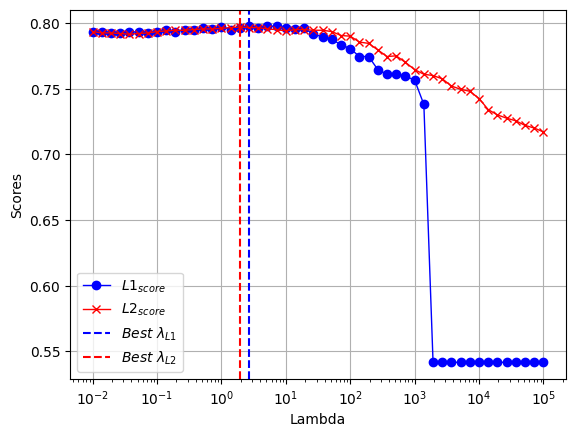

The best lambda for L1 regularization is : 2.6826957952797246
The best lambda for L2 regularization is : 1.9306977288832496


In [226]:
from time import time

# your code here 
# 1) load the data and normalize it 
xs,ys = load_dataset()
ys = label_to_pm_one(ys)
x_add = add_interactions(xs)
x_train, x_val, y_train, y_val = function_normalize(x_add,ys)

# 2) compute the scores for logistic regression with l1 penalty
lambda_range = np.logspace(-2, 5, 50)
l1_score = logistic_l1_crossvalidation(x_train, y_train, x_val, y_val, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
l2_score = logistic_l2_crossvalidation(x_train, y_train, x_val, y_val, lambda_range)

best_lambda_l11 = lambda_range[np.argmax(l1_score)]
best_lambda_l21 = lambda_range[np.argmax(l2_score)]

# 4) plot the scores as a function of lambda_range
#uncomment to visualize the results
plt.figure()
plt.plot(lambda_range, l1_score,'-o', color="blue", label=r"$L1_{score}$", markersize=6, linewidth=1)
plt.plot(lambda_range, l2_score, '-x', color="red", label=r"$L2_{score}$", markersize=6, linewidth=1)
plt.axvline(x=best_lambda_l11, color="blue", linestyle='--', label=r'$Best\ \lambda_{L1}$')
plt.axvline(x=best_lambda_l21, color="red", linestyle='--', label=r'$Best\ \lambda_{L2}$')

plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.grid()
plt.show()

# 5) print the best lambda for l1 and l2 penalties
print(f"The best lambda for L1 regularization is : {best_lambda_l11}")
print(f"The best lambda for L2 regularization is : {best_lambda_l21}")
